<a href="https://colab.research.google.com/github/tomasonjo/blogs/blob/master/llm/langchain_neo4j_tips.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install neo4j openai langchain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# LangChain Cypher search: Tips & Tricks
## How to optimize prompts for Cypher statement generation to retrieve relevant information from Neo4j in your LLM applications

Last time, we looked at how to get started with [Cypher Search in the LangChain](https://towardsdatascience.com/langchain-has-added-cypher-search-cb9d821120d5) library and why you would want to use knowledge graphs in your LLM applications. In this blog post, we will continue to explore various use cases for integrating knowledge graphs into LLM and LangChain applications. Along the way, you will learn how to improve prompts to produce better and more accurate Cypher statements.

Specifically, we will look at how to use the few-shot capabilities of LLMs by providing a couple of Cypher statement examples, which can be used to specify which Cypher statements the LLM should produce, what the results should look like, and more. Additionally, you will learn how you can integrate graph algorithms from the Neo4j Graph Data Science library into your LangChain applications.

## Neo4j environment setup

In this blog post, we will be using the [Twitch dataset that is available in Neo4j Sandbox](https://sandbox.neo4j.com/?usecase=twitch).

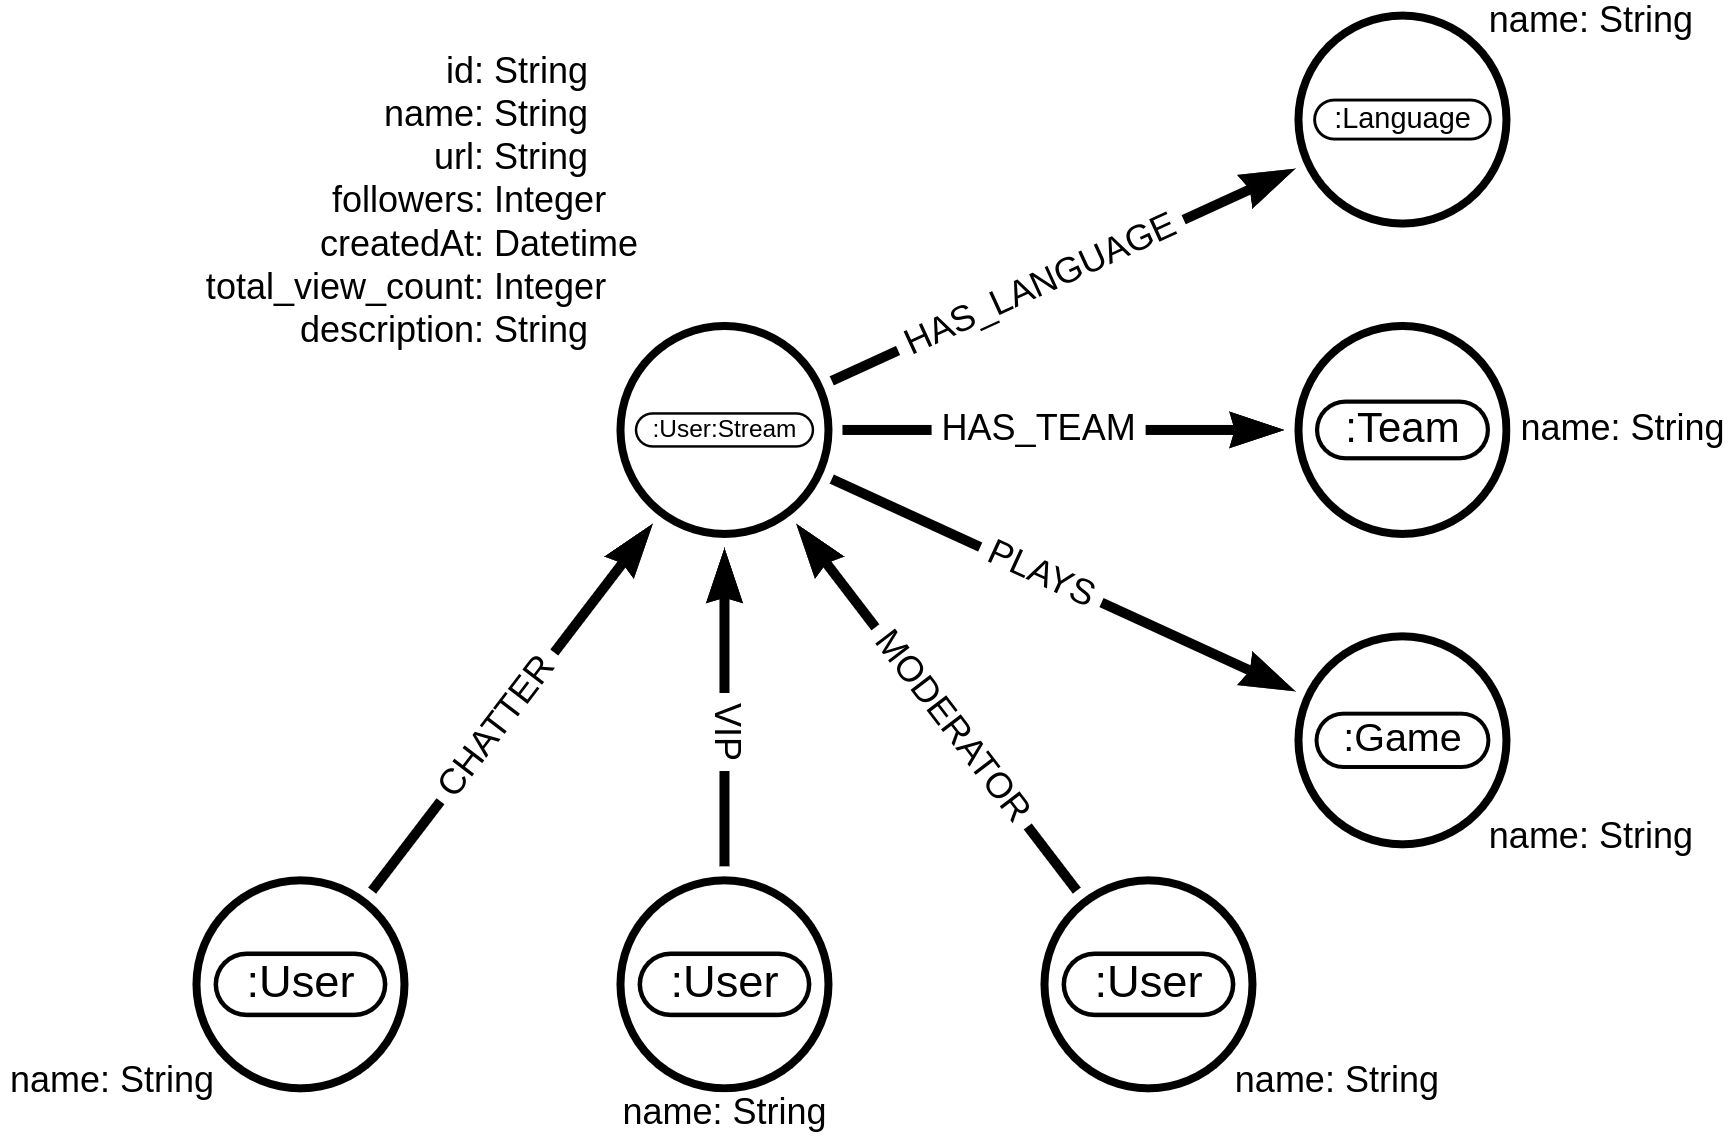

The Twitch social network composes of users. A small percentage of those users broadcast their gameplay or activities through live streams. In the graph model, users who do live streams are tagged with a secondary label Stream. Additional information about which teams they belong to, which games they play on stream, and in which language they present their content is present. We also know how many followers they had at the moment of scraping, the all-time historical view count, and when they created their accounts. The most relevant information for network analysis is knowing which users engaged in the streamer's chat. You can distinguish if the user who chatted in the stream was a regular user (CHATTER relationship), a moderator of the stream (MODERATOR relationship), or a stream VIP.
The network information was scraped between the 7th and the 10th of May 2021. Therefore, the dataset has outdated information.
## Improving LangChain Cypher search
First, we have to setup the LangChain Cypher search.

In [2]:
from langchain.chat_models import ChatOpenAI
from langchain.chains import GraphCypherQAChain
from langchain.graphs import Neo4jGraph

graph = Neo4jGraph(
    url="bolt://44.212.12.199:7687", 
    username="neo4j", 
    password="buoy-warehouse-subordinates"
)

In [3]:
import os

os.environ['OPENAI_API_KEY'] = "OPENAI_API_KEY"

chain = GraphCypherQAChain.from_llm(
    ChatOpenAI(temperature=0), graph=graph, verbose=True,
)

I really love how easy it is go setup the Cypher Search in the LangChain library. You only need to define the Neo4j and OpenAI credentials, and you are good to go. Under the hood, the graph objects inspects the graph schema model and passes it to the GraphCypherQAChain to construct accurate Cypher statements.

Let's begin with a simple question.

In [4]:
chain.run("""
Which fortnite streamer has the most followers?
""")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (s:Stream)-[:PLAYS]->(:Game {name: 'Fortnite'})
RETURN s.name, s.followers
ORDER BY s.followers DESC
LIMIT 1
Full Context:
[{'s.name': 'thegrefg', 's.followers': 7269018}]

> Finished chain.


'According to the provided information, the Fortnite streamer with the most followers is thegrefg, with a total of 7,269,018 followers.'

The Cypher chain constructed a relevant Cypher statement, used it to retrieve information from Neo4j, and provided the answer in natural language form.

Now let's ask another question.

In [5]:
chain.run("""
Which italian streamer has the most followers?
""")



> Entering new GraphCypherQAChain chain...


Generated Cypher:
MATCH (s:Stream)-[:HAS_LANGUAGE]->(:Language {name: 'Italian'})
RETURN s.name, s.followers
ORDER BY s.followers DESC
LIMIT 1
Full Context:
[]

> Finished chain.


"I'm sorry, but I cannot provide an answer to your question as no information has been provided. Please provide more details or a specific name to assist you better."

The generated Cypher statement looks valid, but unfortunately, we didn't get any results. The problem is that the language values are stored as two-character country codes, and the LLM is unaware of that. There are a few options we have to overcome this problem. First, we can utilize the few-shot capabilities of LLMs by providing examples of Cypher statements, which the model then imitates when generating Cypher statements. To add example Cypher statements in the prompt, we have to update the Cypher generating prompt. You can take a look at the default prompt used to generate Cypher statements to better understand the update we are going to do.

In [6]:
# https://github.com/hwchase17/langchain/blob/master/langchain/chains/graph_qa/prompts.py
from langchain.prompts.prompt import PromptTemplate


CYPHER_GENERATION_TEMPLATE = """Task:Generate Cypher statement to query a graph database.
Instructions:
Use only the provided relationship types and properties in the schema.
Do not use any other relationship types or properties that are not provided.
Schema:
{schema}
Cypher examples:
# How many streamers are from Norway?
MATCH (s:Stream)-[:HAS_LANGUAGE]->(:Language {{name: 'no'}})
RETURN count(s) AS streamers

Note: Do not include any explanations or apologies in your responses.
Do not respond to any questions that might ask anything else than for you to construct a Cypher statement.
Do not include any text except the generated Cypher statement.

The question is:
{question}"""
CYPHER_GENERATION_PROMPT = PromptTemplate(
    input_variables=["schema", "question"], template=CYPHER_GENERATION_TEMPLATE
)

If you compare the new Cypher generating prompt to the default one, you can observe we only added the Cypher examples section. We added an example where the model could observe that the language values are given as two-character country codes. Now we can test the improved Cypher chain to answer the question about the most followed Italian streamers.

In [7]:
chain_language_example = GraphCypherQAChain.from_llm(
    ChatOpenAI(temperature=0), graph=graph, verbose=True,
    cypher_prompt=CYPHER_GENERATION_PROMPT
)

chain_language_example.run("""
Which italian streamer has the most followers?
""")




> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (s:Stream)-[:HAS_LANGUAGE]->(:Language {name: 'it'})
WHERE s.followers IS NOT NULL
RETURN s.name AS streamer, s.followers AS followers
ORDER BY followers DESC
LIMIT 1
Full Context:
[{'streamer': 'pow3rtv', 'followers': 1530428}]

> Finished chain.


'According to the provided information, the streamer with the most followers is pow3rtv, with a total of 1530428 followers.'

The model is now aware that the languages are given as two-character country codes and can now accurately answer questions that use the language information.

## Using graph algorithms to answer questions
In the previous blog post, we looked at how integrating graph databases into LLM applications can answer questions like how entities are connected by finding the shortest or other paths between them. Today we will look at another use cases where graph databases can be used in LLM applications that other databases struggle with, specifically how we can use graph algorithms like PageRank to provide relevant answers. For example, we can use personalized PageRank to provide recommendations to an end user at query time.

Take a look at the following example:

In [8]:
chain_language_example.run("""
Which streamers should I also watch if I like pokimane?
""")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (s1:Stream)-[:PLAYS]->(:Game {name: 'League of Legends'})<-[:PLAYS]-(s2:Stream)-[:CHATTER]->(s1)
WHERE s1.name = 'pokimane'
RETURN s2.name AS recommended_streamer
Full Context:
[]

> Finished chain.


'Based on your interest in Pokimane, you may also enjoy watching other popular streamers such as Valkyrae, LilyPichu, and Fuslie. These streamers have similar content and personalities that may appeal to your interests.'

Interestingly, every time we rerun this question, the model will generate a different Cypher statement. However, one thing is consistent. For some reason, every time the League of Legends is somehow included in the query.

A bit more worrying fact is that the LLM model provided recommendations even though it wasn't provided with any suggestions in the prompt context. It's known that gpt-3.5-turbo sometimes doesn't follow the rules, especially if you do not repeat them more than once.

Repeating the instruction three times can help gpt-3.5-turbo solve this problem. However, by repeating instructions, you are increasing the token count and consequently the cost of Cypher generation. Therefore, it would take some prompt engineering to get the best results using the lowest count of tokens.

As mentioned, we will use Personalized PageRank to provide stream recommendations. But first, we need to project the in-memory graph and run the Node Similarity algorithm to prepare the graph to be able to give recommendations. Look at my [previous blog post](https://towardsdatascience.com/twitchverse-a-network-analysis-of-twitch-universe-using-neo4j-graph-data-science-d7218b4453ff) to learn more about how graph algorithms can be used to analyze the Twitch network.

In [9]:
# Project in-memory graph
graph.query("""
CALL gds.graph.project('shared-audience',
  ['User', 'Stream'],
  {CHATTER: {orientation:'REVERSE'}})
""")

# Run node similarity algorithm
graph.query("""
CALL gds.nodeSimilarity.mutate('shared-audience',
 {similarityMetric: 'Jaccard',similarityCutoff:0.05, topK:10, sudo:true,
     mutateProperty:'score', mutateRelationshipType:'SHARED_AUDIENCE'})
""")

[{'preProcessingMillis': 0,
  'computeMillis': 109479,
  'mutateMillis': 39,
  'postProcessingMillis': -1,
  'nodesCompared': 4538,
  'relationshipsWritten': 23609,
  'similarityDistribution': {'p1': 0.05039477348327637,
   'max': 0.9291150569915771,
   'p5': 0.05223870277404785,
   'p90': 0.27272772789001465,
   'p50': 0.08695673942565918,
   'p95': 0.3424661159515381,
   'p10': 0.05494499206542969,
   'p75': 0.14691996574401855,
   'p99': 0.46153998374938965,
   'p25': 0.06399989128112793,
   'p100': 0.9291150569915771,
   'min': 0.04999995231628418,
   'mean': 0.1265612697302399,
   'stdDev': 0.09586148263128431},
  'configuration': {'topK': 10,
   'similarityMetric': 'JACCARD',
   'bottomK': 10,
   'bottomN': 0,
   'mutateRelationshipType': 'SHARED_AUDIENCE',
   'topN': 0,
   'concurrency': 4,
   'jobId': '78d599a8-ae8b-4a5d-8ccb-1471b7b6bbeb',
   'degreeCutoff': 1,
   'similarityCutoff': 0.05,
   'logProgress': True,
   'nodeLabels': ['*'],
   'sudo': True,
   'relationshipTypes':

The node similarity algorithm will take about 30 seconds to complete as the database has almost five million users. The Cypher statement to provide recommendations using Personalized PageRank is the following:

In [10]:
graph.query("""
MATCH (s:Stream)
WHERE s.name = "kimdoe"
WITH collect(s) AS sourceNodes
CALL gds.pageRank.stream("shared-audience", 
  {sourceNodes:sourceNodes, relationshipTypes:['SHARED_AUDIENCE'], 
    nodeLabels:['Stream']})
YIELD nodeId, score
WITH gds.util.asNode(nodeId) AS node, score
WHERE NOT node in sourceNodes
RETURN node.name AS streamer, score
ORDER BY score DESC LIMIT 3
""")

[{'streamer': 'tranth', 'score': 0.13697276805472164},
 {'streamer': 'jungtaejune', 'score': 0.13697276805472164},
 {'streamer': 'hanryang1125', 'score': 0.1051181893540686}]

The OpenAI LLMs could be better at using the Graph Data Science library as their knowledge cutoff is September 2021, and version 2 of the Graph Data Science library was released in April 2022. Therefore, we need to provide another example in the prompt to show the LLM show to use Personalized PageRank to give recommendations.

In [11]:
# https://github.com/hwchase17/langchain/blob/master/langchain/chains/graph_qa/prompts.py

CYPHER_RECOMMENDATION_TEMPLATE = """Task:Generate Cypher statement to query a graph database.
Instructions:
Use only the provided relationship types and properties in the schema.
Do not use any other relationship types or properties that are not provided.
Schema:
{schema}
Cypher examples:
# How many streamers are from Norway?
MATCH (s:Stream)-[:HAS_LANGUAGE]->(:Language {{name: 'no'}})
RETURN count(s) AS streamers
# Which streamers do you recommend if I like kimdoe?
MATCH (s:Stream)
WHERE s.name = "kimdoe"
WITH collect(s) AS sourceNodes
CALL gds.pageRank.stream("shared-audience", 
  {{sourceNodes:sourceNodes, relationshipTypes:['SHARED_AUDIENCE'], 
    nodeLabels:['Stream']}})
YIELD nodeId, score
WITH gds.util.asNode(nodeId) AS node, score
WHERE NOT node in sourceNodes
RETURN node.name AS streamer, score
ORDER BY score DESC LIMIT 3

Note: Do not include any explanations or apologies in your responses.
Do not respond to any questions that might ask anything else than for you to construct a Cypher statement.
Do not include any text except the generated Cypher statement.

The question is:
{question}"""
CYPHER_RECOMMENDATION_PROMPT = PromptTemplate(
    input_variables=["schema", "question"], template=CYPHER_RECOMMENDATION_TEMPLATE
)

We can now test the Personalized PageRank recommendations.

In [12]:
chain_recommendation_example = GraphCypherQAChain.from_llm(
    ChatOpenAI(temperature=0, model_name='gpt-4'), graph=graph, verbose=True,
    cypher_prompt=CYPHER_RECOMMENDATION_PROMPT, 
)

chain_recommendation_example.run("""
Which streamers do you recommend if I like pokimane?
""")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (s:Stream)
WHERE s.name = "pokimane"
WITH collect(s) AS sourceNodes
CALL gds.pageRank.stream("shared-audience", 
  {sourceNodes:sourceNodes, relationshipTypes:['SHARED_AUDIENCE'], 
    nodeLabels:['Stream']})
YIELD nodeId, score
WITH gds.util.asNode(nodeId) AS node, score
WHERE NOT node in sourceNodes
RETURN node.name AS streamer, score
ORDER BY score DESC LIMIT 3
Full Context:
[{'streamer': 'xchocobars', 'score': 0.2343657053097286}, {'streamer': 'ariasaki', 'score': 0.06485239618458194}, {'streamer': 'natsumiii', 'score': 0.05969369486512491}]

> Finished chain.


"Based on the information provided, I recommend checking out the following streamers if you like Pokimane:\n\n1. xchocobars with a score of 0.2344\n2. ariasaki with a score of 0.0649\n3. natsumiii with a score of 0.0597\n\nThese scores indicate their similarity to Pokimane's content and style. Enjoy watching!"

Unfortunately, here, we have to use the gpt-4 model as the gpt-3.5-turbo is stubborn and doesn't want to imitate the complex Personalized PageRank example.

We can also test if the gpt-4 model will decide to generalize the Personalized PageRank recommendation in other use cases.

In [13]:
chain_recommendation_example.run("""
Which streamers do you recommend to watch if I like Chess games?
""")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (s:Stream)-[:PLAYS]->(:Game {name: 'Chess'})
RETURN s.name AS streamer
ORDER BY s.followers DESC LIMIT 10
Full Context:
[{'streamer': 'gmhikaru'}, {'streamer': 'thisisnotgeorgenotfound'}, {'streamer': 'gothamchess'}, {'streamer': 'mates'}, {'streamer': 'akanemsko'}, {'streamer': 'xntentacion'}, {'streamer': 'chessbrah'}, {'streamer': 'inet_saju'}, {'streamer': 'annacramling'}, {'streamer': 'michelleputtini'}]

> Finished chain.


'I recommend the following chess streamers for you to watch: gmhikaru, thisisnotgeorgenotfound, gothamchess, mates, akanemsko, xntentacion, chessbrah, inet_saju, annacramling, and michelleputtini. Enjoy watching their chess games!'

The LLM decided to take a more straightforward route to provide recommendations and simply returned the three chess players with the highest follower count. We can't really blame it for choosing this option.

However, LLMs are quite good at listening to hints:

In [14]:
chain_recommendation_example.run("""
Which streamers do you recommend to watch if I like Chess games?
Use Personalized PageRank to provide recommendations.
Do not exclude sourceNodes in the answer
""")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (s:Stream)-[:PLAYS]->(:Game {name: 'Chess'})
WITH collect(s) AS sourceNodes
CALL gds.pageRank.stream("shared-audience", 
  {sourceNodes:sourceNodes, relationshipTypes:['SHARED_AUDIENCE'], 
    nodeLabels:['Stream']})
YIELD nodeId, score
WITH gds.util.asNode(nodeId) AS node, score
RETURN node.name AS streamer, score
ORDER BY score DESC LIMIT 3
Full Context:
[{'streamer': 'segonaye', 'score': 1.1104359051332637}, {'streamer': 'dafatw01', 'score': 0.978557815808113}, {'streamer': 'chessbrah', 'score': 0.9612404689154856}]

> Finished chain.


'Based on the Personalized PageRank algorithm, I recommend the following streamers for watching Chess games:\n\n1. segonaye with a score of 1.1104359051332637\n2. dafatw01 with a score of 0.978557815808113\n3. chessbrah with a score of 0.9612404689154856\n\nThese streamers have been ranked according to their relevance to Chess games. Enjoy watching!'

## Summary
In this blog post, we expanded on using knowledge graphs in LangChain applications, focusing on improving prompts for better Cypher statements. The main opportunity to improve the Cypher generation accuracy is to use the few-shot capabilities of LLMs, offering Cypher statement examples that dictate the type of statements an LLM should produce. Sometimes, the LLM model doesn't correctly guess the property values, while other times, it doesn't provide the Cypher statements we would like it to generate. Additionally, we have looked at how we can use graph algorithms like Personalized PageRank in LLM applications to provide better and more relevant answers.